# 2020 November 21

In [2]:
# julia imports
using CCDReduction
using HCIToolbox
using ImageFiltering
using InvertedIndices
using Logging
using PlotUtils
using ProgressMeter
using PyCall
using PyPlot
using SAOImageDS9
using SiriusB
using Statistics

In [10]:
# python imports
hp = pyimport("hciplot")
fits = pyimport("astropy.io.fits")
lac = pyimport("lacosmic")
skr = pyimport("skimage.registration");

In [5]:
# set up DS9 connection
DS9.connect()

"7f000001:65416"

In [6]:
# build this plotting command because hciplot doesn't respect default cmap
# nor has built-in zscale support
function plot_frames(frames...; cmap="inferno", zscale=false, kwargs...)
    data = Matrix.(Tuple(frames))
    if zscale
        clims = map(PlotUtils.zscale, data)
        vmin = map(first, clims)
        vmax = map(last, clims)
    else
        vmin = vmax = nothing
    end
    return hp.plot_frames(data; cmap=cmap, vmin=vmin, vmax=vmax, kwargs...)
end

plot_frames (generic function with 1 method)

## Build Collections

`CCDReduction.fitscollection` creates a table with the paths, names, and header information for every file in a directory. This lets us filter through and target the flats, darks, and science frames simply

In [7]:
collection = fitscollection(datadir("epoch_2020nov21", "raw data"));

In [8]:
# separate files into respective types
sky_flats = filter(row -> row.OBJECT == "flat2" && row.COADDS == 75, collection)
sci = filter(row -> row.OBJECT == "alf CMa b off" && row.COADDS == 75, collection);

In [9]:
# set up path for processing of this epoch
procdir(args...) = datadir("epoch_2020nov21", "processed", args...)
mkpath(procdir());

## Calibration

Build the master flat from the sky flats (which worked better than dome flats) using a median combination.

In [11]:
master_flat = combine(arrays(sky_flats));

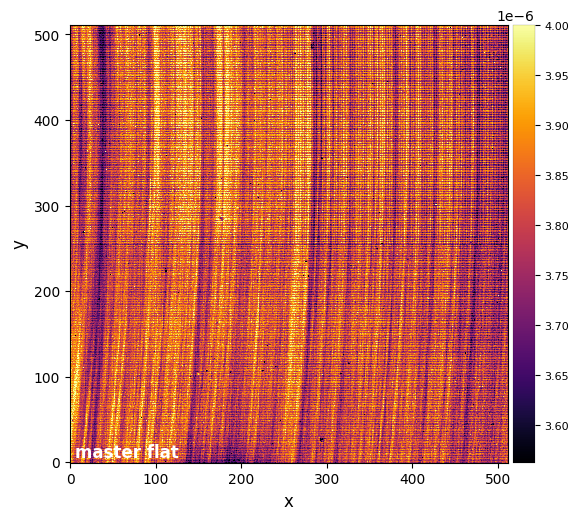

In [12]:
plot_frames(
    master_flat ./ sum(master_flat);
    zscale=true,
    label="master flat"
)

In [13]:
fits.writeto(procdir("2020nov21_master_flat.fits"), master_flat, overwrite=true)

For calibrating the science frames, first normalize using the master flat, then use LACosmic to detect bad pixels. Bad pixels are automatically corrected by LACosmic via median replacement.

For the LACosmic keywords, since we are imaging on NIRC2 with the narrow pupil (10 mas/px) in Lp band, we are sampling ~4 px per FWHM, so we are supersampling by a factor of 2 or more, so the contrast is set to 1 to reflect this (LACosmic manual says `contrast=2` corresponds to perfectly sampled (2 px/FWHM) data)

In [18]:
# filter out astropy logs because LACosmic emits a ton
# which bloat the output
py"""
from astropy import log
log.setLevel("WARNING")
"""

function calib_pipeline(ccd)
    f1 = flat_correct(ccd, master_flat, norm_value=median(master_flat))
    f2, bp_mask = lac.lacosmic(
        Matrix(f1); 
        effective_gain=ccd["GAIN"],
        contrast = 1, # oversampled, choose between 1-2
        cr_threshold = 3.5, # S/N threshold for bad pixel rejection
        neighbor_threshold = 4, # S/N threshold for detection of bad pixels within the same block (mesh)
        readnoise = 38 # e-/px from https://www2.keck.hawaii.edu/koa/public/nirc2/nirc2_data_form.html (CDS mode)
    )
    bkg = mapwindow(median, f2, (31, 31))
    return f2 .- bkg
end

calib_pipeline (generic function with 1 method)

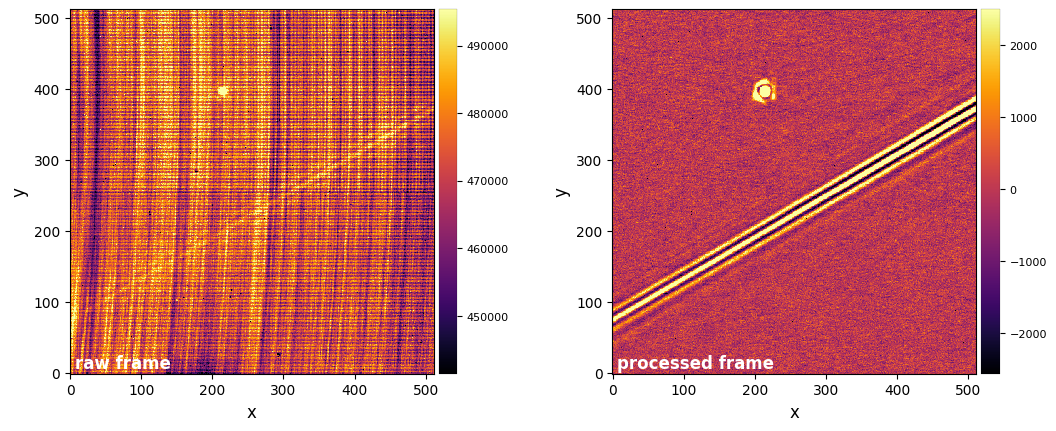

In [19]:
ccd = collect(ccds(sci))[18]
plot_frames(
    ccd,
    calib_pipeline(ccd);
    zscale=true,
    label=("raw frame", "processed frame")
)

In [20]:
pbar = Progress(size(sci, 1))

calib_frames = ccds(sci) do ccd
    next!(pbar)
    return calib_pipeline(ccd)
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:39:14


In [21]:
# manually inspect frames
DS9.set(permutedims(cat(calib_frames..., dims=3), (2, 1, 3)))

In [73]:
bad_frames_idx = vcat(1:11, 38:46, 67:71, 192:239)
good_frames = calib_frames[Not(bad_frames_idx)];

In [74]:
good_frames_cube = permutedims(cat(good_frames..., dims=3), (3, 1, 2))
fits.writeto(procdir("2020nov21_sirius-b_cube_calib.fits"), good_frames_cube, overwrite=true);

## Alignment

Next we will use a 2D Gaussian PSF to align each frame to a common position (the center). It took me far too much work to find an algorithmic way of doing this well with bad pixels and large background noise, so the initial centers are found by eye and used as starting points.

In [28]:
DS9.set(permutedims(cat(good_frames..., dims=3), (2, 1, 3)));

First we need to find the offset of the first frame

In [75]:
# code in src/fitting.jl
reference_unshifted = good_frames[28]
first_shift = gaussian_fit_offset(reference_unshifted, (252, 140))
reference = shift_frame(reference_unshifted, first_shift...);

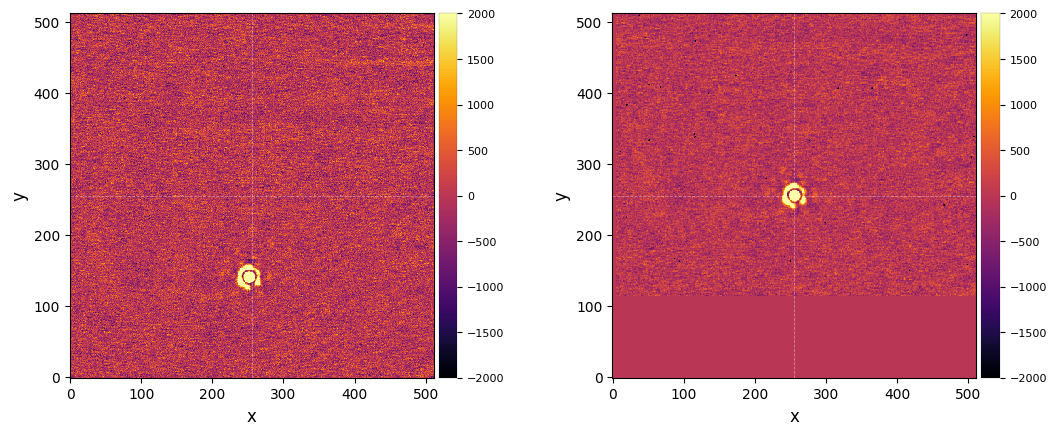

In [76]:
plot_frames(
    reference_unshifted,
    reference;
    cross=(255.5, 255.5), # center is -1 in python
    vmin=2e3,
    vmax=-2e3
)

Now, we need to shift the entire cube using this shift and find the correlation between subsequent frames and the first frame. The correlation will let us measure the offset between these frames and should allow us to register everything to the center.

In [77]:
shifted_frames = map(f -> shift_frame(f, first_shift...), good_frames);

In [78]:
function dft_register(frame,
        sub_size=400,
        ref=reference)
    target = frame
    shift = skr.phase_cross_correlation(ref, target; return_error=false, upsample_factor=100)
    return shift_frame(frame, reverse(shift)...)
end

dft_register (generic function with 3 methods)

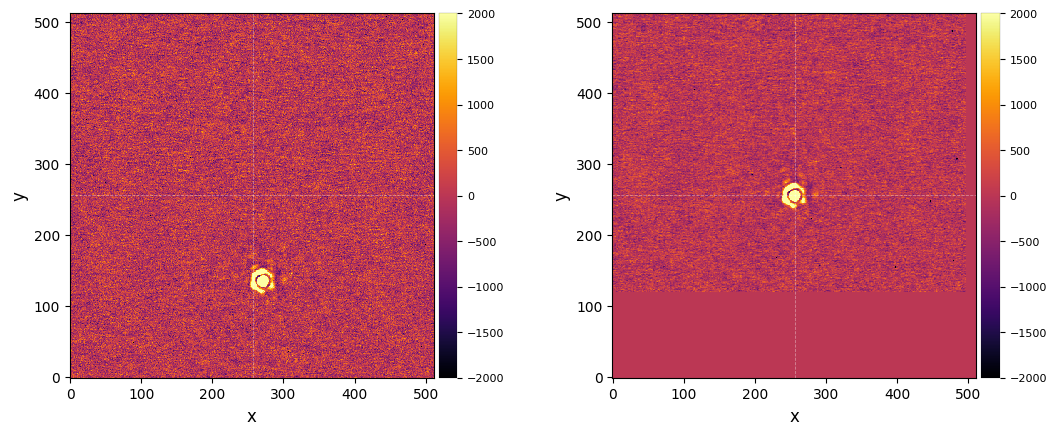

In [79]:
N = 246
test_out = dft_register(good_frames[N]);

plot_frames(
    good_frames[N],
    test_out,
    cross=(256.5, 256.5), # center is -1 in python
    vmin=2e3,
    vmax=-2e3
)

In [80]:
aligned_frames = @showprogress map(dft_register, good_frames);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


In [66]:
DS9.set(permutedims(cat(aligned_frames..., dims=3), (2, 1, 3)))

see if local gaussian PSF fitting improves output. This needs to be better than the 1/`upsample_factor` precision delivered by the DFT registration

In [81]:
aligned_frames_2 = @showprogress map(aligned_frames) do frame
    shift = gaussian_fit_offset(frame)
    shift_frame(frame, shift...)
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


In [82]:
DS9.set(permutedims(cat(aligned_frames_2..., dims=3), (2, 1, 3)))

In [83]:
aligned_frames_cube = permutedims(cat(aligned_frames_2..., dims=3), (3, 1, 2))
fits.writeto(procdir("2020nov21_sirius-b_cube_calib_registered.fits"), aligned_frames_cube, overwrite=true);

finally crop to an interior angle, in this case (with a plate scale of 10 mas/px), the outer radius is 1 arc second, which is ~2.6 AU

In [84]:
crop_frames = map(f -> HCIToolbox.crop(f, 200), aligned_frames_2);

In [90]:
DS9.set(permutedims(cat(crop_frames..., dims=3), (2, 1, 3)))

In [85]:
crop_frames_cube = permutedims(cat(crop_frames..., dims=3), (3, 1, 2))
fits.writeto(procdir("2020nov21_sirius-b_cube_calib_registered_crop.fits"), crop_frames_cube, overwrite=true);

## Calculate parallactic angles

In [86]:
# use Yelda et al. (2010) solution for calculating PA accounting 
# for distortion and instrumental effects (in src/SiriusB.jl)
angles = parallactic_angles(sci[Not(bad_frames_idx), :path]);

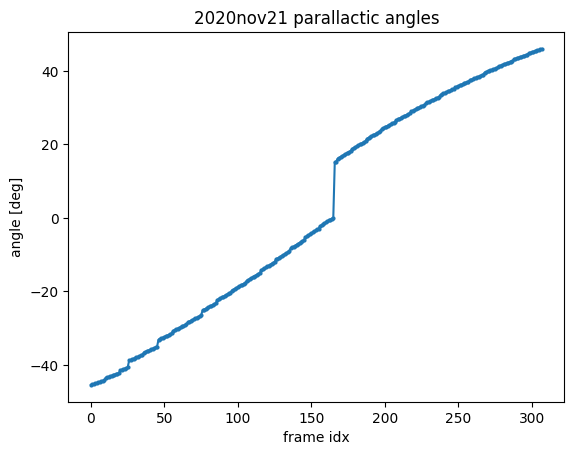

In [88]:
plot(angles, marker=".", markersize=4)
title("2020nov21 parallactic angles")
xlabel("frame idx")
ylabel("angle [deg]");

In [89]:
fits.writeto(procdir("2020nov21_sirius-b_pa.fits"), angles, overwrite=true);